# HW 11-1
## Abby Baskind
## 21 November 2023

In [1]:
%cd /Users/akbaskind/Documents/Python Scripts/OCG577

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
import H_poly2 as hpoly2
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

/Users/akbaskind/Documents/Python Scripts/OCG577


In [14]:
def threeboxmodel(time, dt, DIC = None, T = None, S = None, TA = None, **kwargs):
    
    """
    Currently, the 3 box model only advects DIC. 
    
    INPUTS:
        - time [year]
        - dt [year]
        - DIC [umol/kg]
        - T [°C]
        - S [PSU]
        - TA [umol/kg]
    
    OPTIONAL INPUTS:
        - dx [m]
        - dy [m]
        - dz [m]
        - k(i,j) [m3/s]
        - phi [m3/s]
    """
    
    import numpy as np
    import calc_coeffs as co2
    import carbon as carbon
    
    # # REQUIRED INPUTS *********************************************************************************
    # Check DIC input has length 3 and set initial concentrations
    # units [umol/kg]
    if len(DIC) != 3:
        raise ValueError('Length of DUC initial concentrations does not match number of boxes (3).')
    else:
        DIC1_0 = DIC[0]
        DIC2_0 = DIC[1]
        DIC3_0 = DIC[2]
    
    # Check temperature input has length 3
    # units [°C]
    if len(T) != 3:
        raise ValueError('Length of initial temperature does not match number of boxes (3).')
    
    # Check salinity input has length 3
    # units [PSU]
    if len(S) != 3:
        raise ValueError('Length of initial salinity does not match number of boxes (3).')
    
    # Check TA input has length 3
    # units [umol/kg]
    if len(TA) != 3:
        raise ValueError('Length of initial TA does not match number of boxes (3).')
    
    # Convert time from years to seconds
    # year * (365 day/1 year) * (24 hours/1 day) * (60 min/1 hour) * (60 s/1 min)
    time = time * 365 * 24 * 60 * 60
    dt = dt * 365 * 24 * 60 * 60
    TIME = np.arange(0,time,dt)         # duration [s]
    
    # # OPTIONAL ARGS *******************************************************************
    # Keyword arguments can change the size of the boxes
    # dx, dy, dz, phi, k13, k23, k21, k31, k32, k12
    
    defaults = {'dx': np.array([17e6, 17e6, 17e6]),    # default dx = 17000 km
                'dy': np.array([8e6, 8e6, 16e6]),      # default dy = [8000 km, 8000 km, 16000 km]
                'dz': np.array([100, 100, 5000]),      # default dz = [100m, 100m, 5000m]
                'phi': 20e6, 
                'k13': 1e6,
                'k23': 1e6,
                'k12': 1e6,
                'k31': 1e6,
                'k32': 1e6,
                'k21': 1e6,
                'pCO2atm': 280,                        # default pCO2atm = 280 ppmv
                'kg': 5e-5}                            # default kg = 5*10^-5 m/s
    
    for key in defaults:
        if key in kwargs:
            data = kwargs.get(key)
            if type(data) == list:
                data = np.array(data)
            defaults[key] = data
    
    dx = defaults['dx']         # longitude (m)
    dy = defaults['dy']         # latitude (m)
    dz = defaults['dz']         # depth (m)
    phi = defaults['phi']       # m^3/s
    k13 = defaults['k13']       # m^3/s
    k23 = defaults['k23']       # m^3/s
    k12 = defaults['k12']       # m^3/s
    k32 = defaults['k32']       # m^3/s
    k31 = defaults['k31']       # m^3/s
    k21 = defaults['k21']       # m^3/s
    pCO2atm = defaults['pCO2atm']   # uatm
    kg = defaults['kg']         # m/s  
     
    # # BOX VOLUME
    # Default volumes: [1.36e+16 m3, 1.36e+16 m3, 1.36e+18 m3]
    # Calculate Volume
    V = dx * dy * dz                    # volume of each box (m^3)
    
    # # ATMOSPHERE
    # Total mass of atmosphere = 1.8e20 mol
    # Total mass of atmosphere = 1.8e26 umol
    Matm = 1.8e26
    XCO2_0 = pCO2atm                    # initial mixing ratio = 280 ppmv

    # # STORAGE ARRAYS *************************************************************************
    # Arrays to store concentrations over time
    DIC1 = np.zeros(len(TIME))
    DIC2 = np.zeros(len(TIME))
    DIC3 = np.zeros(len(TIME))
    PCO21 = np.zeros(len(TIME))
    PCO22= np.zeros(len(TIME))
    PCO23 = np.zeros(len(TIME))
    XCO2 = np.zeros(len(TIME))

    # # TIME STEP LOOP ***********************************************************************************
    for k in range(len(TIME)):
        
        # Calculate solubility 
        # k0 = [mol/kg/atm] = [umol/kg/uatm]
        coeffs = co2.calc_coeffs(T,S)
        k0_1 = coeffs['k0'][0] 
        k0_2 = coeffs['k0'][1] 
        k0_3 = coeffs['k0'][2] 
        
        # Calculate density [kg/m3]
        # My carbon package can solve for density 
        # So I have opted to solve for density rather than use constant density
        [rho1,rho2,rho3] = carbon.density_1atm(T,S)
        
        # Calculate pCO2
        # Input units [umol/kg]
        # pCO2 units [uatm]
        results = carbon.solver(DIC = np.array([DIC1_0,DIC2_0,DIC3_0]), TA = TA, temperature = T, salinity = S)
        pCO2_1 = results['pCO2'][0]
        pCO2_2 = results['pCO2'][1]
        pCO2_3 = results['pCO2'][2]
        PCO21[k] = pCO2_1
        PCO22[k] = pCO2_2
        PCO23[k] = pCO2_3
        
        # Calculate FCO2 for surface boxes (Box 1 and Box 2)
        # FCO2 for Box 3 = 0 -- not at air sea interface
        # [umol/kg] * [kg/m3] * [umol/(kg * atm)]
        # [umol/m2s] = [kg/m3] * [m/s] * [umol/kg uatm] * [uatm]
        # Changed pCO2atm to XCO2_0 (initial mixing ratio) since that
        # updates through every time step
        FCO2_1 = rho1 * kg * k0_1 * (XCO2_0 - pCO2_1)
        FCO2_2 = rho2 * kg * k0_2 * (XCO2_0 - pCO2_2)
        FCO2_3 = 0
        
        # Calculate air sea flux (ASF)
        # FCO2 * ∆x * ∆y /ρo
        # [umol/kg/s] = [umol/m2s] * [m] * [m] * [m3/kg]
        ASF1 = FCO2_1 * dx[0] * dy[0] / rho1
        # print(ASF1/V[0])
        ASF2 = FCO2_2 * dx[1] * dy[1] / rho2
        ASF3 = FCO2_3 * dx[2] * dy[2] / rho3
        
        if k > 0:
    
            dDIC1dt = (1/V[0])*(phi*(DIC3[k-1]-DIC1[k-1]) + k31*(DIC3[k-1]-DIC1[k-1]) + k21*(DIC2[k-1]-DIC1[k-1])) + ASF1/V[0]
            dDIC2dt = (1/V[1])*(phi*(DIC1[k-1]-DIC2[k-1]) + k12*(DIC1[k-1]-DIC2[k-1]) + k32*(DIC3[k-1]-DIC2[k-1]) + ASF2)
            dDIC3dt = (1/V[2])*(phi*(DIC2[k-1]-DIC3[k-1]) + k23*(DIC2[k-1]-DIC3[k-1]) + k13*(DIC1[k-1]-DIC3[k-1]))
            dXCO2dt = (-1/Matm)*(FCO2_1 * dx[0] * dy[0] + FCO2_2 * dx[1] * dy[1])
        
        else:
            dDIC1dt = 0
            dDIC2dt = 0
            dDIC3dt = 0
            dXCO2dt = 0
        
        # Calculate concentration at time t
        DIC1[k] = DIC1_0 + dDIC1dt * dt
        DIC2[k] = DIC2_0 + dDIC2dt * dt
        DIC3[k] = DIC3_0 + dDIC3dt * dt
        XCO2[k] = XCO2_0 + dXCO2dt * dt
    
        # Set initial (aka C(t-1)) to latest solution
        DIC1_0 = DIC1[k]
        DIC2_0 = DIC2[k]
        DIC3_0 = DIC3[k]
        XCO2_0 = XCO2[k]
        
    TOTAL = DIC1 * V[0] + DIC2 * V[1] + DIC3 * V[2]
        
    data = {
        'Box 1 DIC Concentration [umol/kg]': DIC1,
        'Box 2 DIC Concentration [umol/kg]': DIC2,
        'Box 3 DIC Concentration [umol/kg]': DIC3,
        'Box 1 pCO2 [uatm]': PCO21,
        'Box 2 pCO2 [uatm]': PCO22,
        'Box 3 pCO2 [uatm]': PCO23,
        'Box 1 Volume': V[0],
        'Box 2 Volume': V[1],
        'Box 3 Volume': V[2],
        'Box 1 density': rho1,
        'Box 2 density': rho2,
        'Box 3 density': rho3,
        'pCO2atm': pCO2atm,
        'Box 1 Total DIC [umol]': DIC1 * V[0],
        'Box 2 Total DIC [umol]': DIC2 * V[1],
        'Box 3 Total DIC [umol]': DIC3 * V[2],
        'TOTAL': TOTAL,
        't [yr]': TIME,
        'XCO2': XCO2
        }
    return data

```python
# Calculate FCO2 for surface boxes (Box 1 and Box 2)
# FCO2 for Box 3 = 0 -- not at air sea interface
# [umol/kg] * [kg/m3] * [umol/(kg * atm)]
FCO2_1 = rho1 * kg * k0_1 * (pCO2atm - pCO2_1)
FCO2_2 = rho2 * kg * k0_2 * (pCO2atm - pCO2_2)
FCO2_3 = 0
        
# Calculate air sea flux (ASF)
# FCO2 * ∆x * ∆y /ρo
ASF1 = FCO2_1 * dx[0] * dy[0] / rho1
ASF2 = FCO2_2 * dx[1] * dy[1] / rho2
ASF3 = FCO2_3 * dx[2] * dy[2] / rho3
    
dDIC1dt = (1/V[0])*(phi*(DIC3_0-DIC1_0) + k31*(DIC3_0-DIC1_0) + k21*(DIC2_0-DIC1_0) + ASF1)
dDIC2dt = (1/V[1])*(phi*(DIC1_0-DIC2_0) + k12*(DIC1_0-DIC2_0) + k32*(DIC3_0-DIC2_0) + ASF2)
dDIC3dt = (1/V[2])*(phi*(DIC2_0-DIC3_0) + k23*(DIC2_0-DIC3_0) + k13*(DIC1_0-DIC3_0) + ASF3)
```

$$
\frac{\partial \text{DIC}_1}{\partial \text{t}} = \frac{1}{\text{V}_1} * ( \phi (\text{DIC}_3 - \text{DIC}_1) + \text{k}_{3,1} (\text{DIC}_3 - \text{DIC}_1) + \text{k}_{2,1} (\text{DIC}_2 - \text{DIC}_1) + \text{k}_{\text{g}} \text{k}_0 \partial \text{x}_1 \partial \text{y}_1 * (\text{pCO2}_2^{\text{atm}} - \text{pCO2}_2^{\text{Box 1}}))
$$ 

$$
\frac{\partial \text{DIC}_2}{\partial \text{t}} = \frac{1}{\text{V}_2} * ( \phi (\text{DIC}_1 - \text{DIC}_2) + \text{k}_{1,2} (\text{DIC}_1 - \text{DIC}_2) + \text{k}_{3,2} (\text{DIC}_3 - \text{DIC}_2) + \text{k}_{\text{g}} \text{k}_0 \partial \text{x}_2 \partial \text{y}_2 * (\text{pCO2}_2^{\text{atm}} - \text{pCO2}_2^{\text{Box 2}}))
$$ 

$$
\frac{\partial \text{DIC}_3}{\partial \text{t}} = \frac{1}{\text{V}_3} * ( \phi (\text{DIC}_2 - \text{DIC}_3) + \text{k}_{2,3} (\text{DIC}_2 - \text{DIC}_3) + \text{k}_{1,3} (\text{DIC}_1 - \text{DIC}_3) + 0)
$$ 

Since Box 3 has no air-sea interface, it does not undergo air sea gas exchange. 

# Simulation with DIC in steady state with XCO2 = 280 ppmv and interactive atmosphere

Text(0, 0.5, 'pCO2 [uatm]')

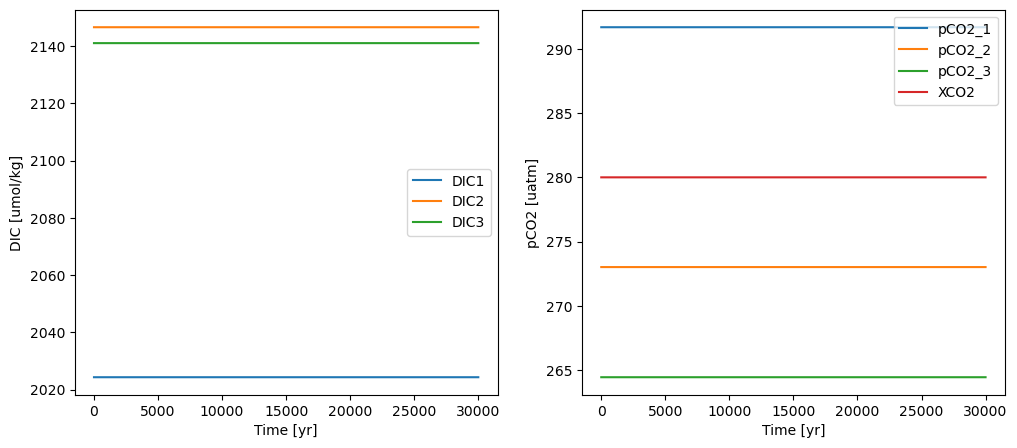

In [38]:
import carbon as carbon
T = np.array([20,4,4])
S = np.array([35,34.5,34.5])
DIC = np.array([dic1,dic2,dic3])
TA = np.array([2350,2350,2350])

results = threeboxmodel(30000,1,DIC = DIC, TA = TA, T = T, S = S)

fig, axarr = plt.subplots(ncols = 2, figsize = [12,5])
axarr = axarr.flatten()
ax = axarr[0]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 DIC Concentration [umol/kg]'], label = 'DIC1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 DIC Concentration [umol/kg]'], label = 'DIC2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 DIC Concentration [umol/kg]'], label = 'DIC3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('DIC [umol/kg]')

ax = axarr[1]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 pCO2 [uatm]'], label = 'pCO2_1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 pCO2 [uatm]'], label = 'pCO2_2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 pCO2 [uatm]'], label = 'pCO2_3')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['XCO2'], label = 'XCO2')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('pCO2 [uatm]')



Text(0, 0.5, 'pCO2 [uatm]')

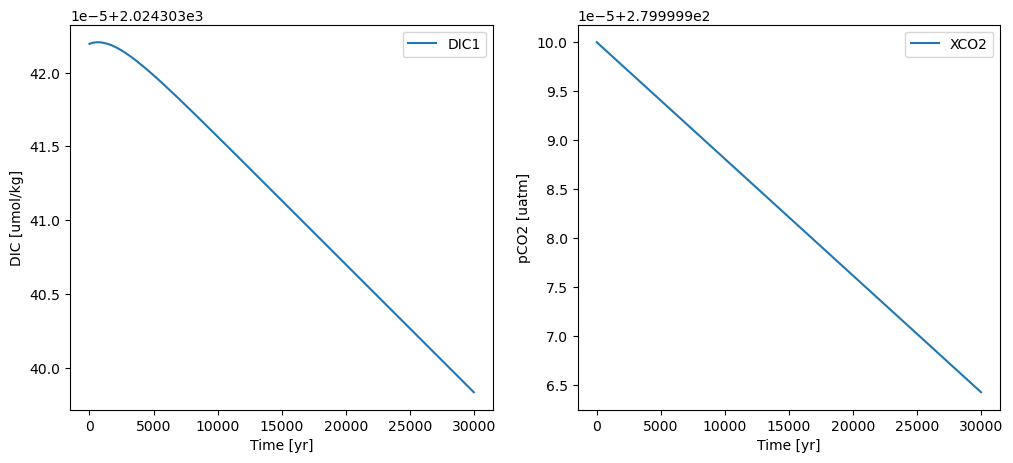

In [21]:
fig, axarr = plt.subplots(ncols = 2, figsize = [12,5])
axarr = axarr.flatten()
ax = axarr[0]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 DIC Concentration [umol/kg]'], label = 'DIC1')
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 DIC Concentration [umol/kg]'], label = 'DIC2')
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 DIC Concentration [umol/kg]'], label = 'DIC3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('DIC [umol/kg]')

ax = axarr[1]
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 pCO2 [uatm]'], label = 'pCO2_1')
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 pCO2 [uatm]'], label = 'pCO2_2')
# ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 pCO2 [uatm]'], label = 'pCO2_3')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['XCO2'], label = 'XCO2')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('pCO2 [uatm]')


In [22]:
results['XCO2']

array([280.        , 280.        , 280.        , ..., 279.99996425,
       279.99996425, 279.99996425])

After reaching steady state with a constant XCO2 of 280 ppmv, implementing a varying atmospheric mixing ratio results in the mixing ratio of the atmosphere decreasing slightly over time (VERY slightly, like pretty much negligible). Additionally, DIC in the surface box decreases *slightly*/negligibly.

This makes sense since, after the ocean reaches equilibrium with XCO2 = 280 ppmv, the air sea flux should go to 0 with no gradient in concentration between the air-sea interface. Even with an interactive atmosphere box, the CO2 of either the atmosphere or ocean should not change with a 0 flux. Indeed the change in the ocean inventory of DIC or pCO2 and the atmosphere inventory of pCO2 changes well below any detection limit

# Below, I run the simulation with initial DIC not in steady state but an interactive atmosphere the whole time.

Text(0, 0.5, 'pCO2 [uatm]')

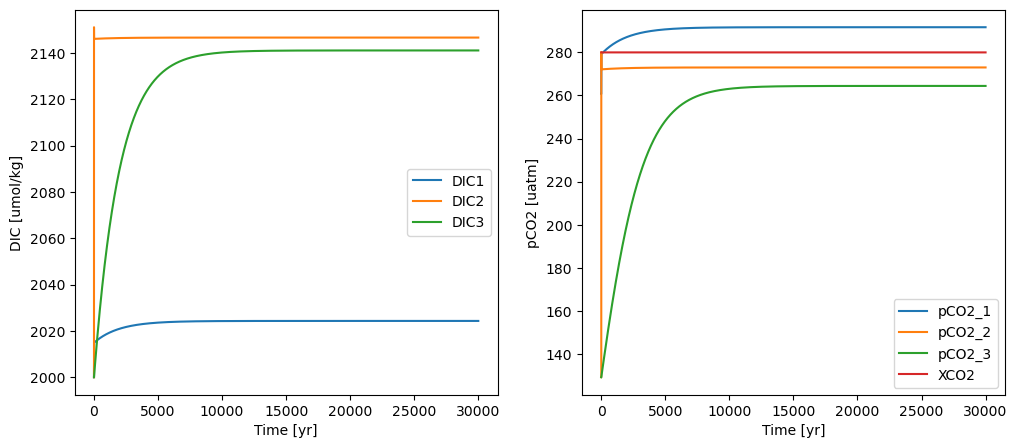

In [23]:
import carbon as carbon
T = np.array([20,4,4])
S = np.array([35,34.5,34.5])
DIC = np.array([2000,2000,2000])
TA = np.array([2350,2350,2350])

results = threeboxmodel(30000,1,DIC = DIC, TA = TA, T = T, S = S)

fig, axarr = plt.subplots(ncols = 2, figsize = [12,5])
axarr = axarr.flatten()
ax = axarr[0]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 DIC Concentration [umol/kg]'], label = 'DIC1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 DIC Concentration [umol/kg]'], label = 'DIC2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 DIC Concentration [umol/kg]'], label = 'DIC3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('DIC [umol/kg]')

ax = axarr[1]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 pCO2 [uatm]'], label = 'pCO2_1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 pCO2 [uatm]'], label = 'pCO2_2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 pCO2 [uatm]'], label = 'pCO2_3')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['XCO2'], label = 'XCO2')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('pCO2 [uatm]')



In [24]:
results['XCO2']

array([280.        , 279.99998924, 279.99998676, ..., 279.99885901,
       279.99885901, 279.99885901])

Similar to the previous run, atmospheric XCO2 decreases from 280 ppmv negligibly, even when for the entire duration of the run atmospheric CO2 is depleted. This makes sense since the mass of the atmosphere is sufficiently large that even when the absolute quantity of CO2 decreases (such that it goes into the ocean) the mixing ratio changes very little.

# Decrease high lat surface temp to 4°C
DIC in each box starts at equilibrium with 280 ppmv and non-glacial temperatures.

Text(0, 0.5, 'pCO2 [uatm]')

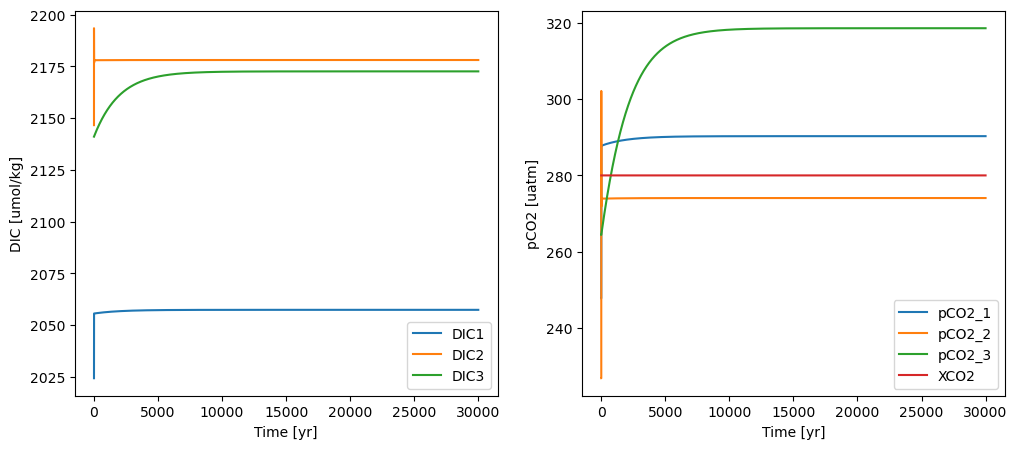

In [49]:
T = np.array([16,0,4])
S = np.array([35,34.5,34.5])
DIC = np.array([dic1,dic2,dic3])
TA = np.array([2350,2350,2350])

results = threeboxmodel(30000,1,DIC = DIC, TA = TA, T = T, S = S)

fig, axarr = plt.subplots(ncols = 2, figsize = [12,5])
axarr = axarr.flatten()
ax = axarr[0]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 DIC Concentration [umol/kg]'], label = 'DIC1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 DIC Concentration [umol/kg]'], label = 'DIC2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 DIC Concentration [umol/kg]'], label = 'DIC3')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('DIC [umol/kg]')

ax = axarr[1]
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 1 pCO2 [uatm]'], label = 'pCO2_1')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 2 pCO2 [uatm]'], label = 'pCO2_2')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['Box 3 pCO2 [uatm]'], label = 'pCO2_3')
ax.plot(results['t [yr]']/(365 * 24 * 60 * 60), results['XCO2'], label = 'XCO2')
ax.legend()
ax.set_xlabel('Time [yr]')
ax.set_ylabel('pCO2 [uatm]')



In [46]:
end = len(results['Box 1 DIC Concentration [umol/kg]'])-1
results['XCO2'][end]

279.99996424918527

In [50]:
T

array([16,  0,  4])

## a.	How long does it take for the ocean-atmosphere carbon system to come into equilibrium with a change in temperature in your model? What sets that timescale? 

The ocean atmosphere system comes into equilibrium after approx. 7000 years when T(2) = 0°. At T(2) = 4°C, the system is already in equilibrium.

## b.	How would this change in temperature affect atmospheric CO2 according to your model of the solubility pump?

The decrease in temperature in the high latitude box increases solubility of CO2. This increases DIC in box 2 by \~30 umol/kg. This also increases DIC in Box 1 by 2 umol/kg. DIC in Box 3 increases by \~30 umol/kg as well. pCO2 in Box 1 and Box 2 change only slightly, by about 1-2 uatm each. pCO2 in Box 3 increases by a lot (~60 uatm). XCO2 changes negligibly. This is all to say, based on the model, the solubility pump alone cannot replication the drop in atmospheric CO2 seen in the LGM.

* When T$_2$ = 0°C
    * DIC1 = 2026.2949960854203
    * DIC2 = 2177.242253145844
    * DIC3 = 2170.381008946474
    * pCO21 = 294.4152250422601
    * pCO22 = 272.59129002527374
    * pCO23 = 314.22287674385154
    * XCO2 = 279.9997212796431
* When T$_2$ = 4°C
    * DIC1 = 2024.3033983544258
    * DIC2 = 2146.6373669005
    * DIC3 = 2141.076733466498
    * pCO21 = 291.68289178782663
    * pCO22 = 273.0163611439069
    * pCO23 = 264.4443916812932
    * XCO2 = 279.99996424918527
    
## Comment on your answer relative to changes in CO2 from ice core records (figure below). How did the solubility pump affect atmospheric CO2 in glacial periods? (hint: during the Last Glacial Maximum (~20000 years ago), CO2 p_{CO2}^{at} was much lower than today)

It seems (if my model is correct, it may not be) that the solubility pump alone did not cause the decline in CO2 seen in the LGM. If this is true, other sinks of CO2 need to be considered: greater carbonate formation and burial, an biological pump efficient at exporting carbon to the deep ocean, etc. 